In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn import linear_model
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sgf
from scipy.signal import find_peaks
import matplotlib as mpl
'''
A bunch of small helper functions

'''
def scale(array):
    m = max(array)
    return array/m

def zero(array,num1=350):
    return array - np.average(array[num1:])

def binning(array,num):
    binarray=[]
    for i in range(int(len(array)/num)):
        binarray.append(np.average(array[num*i:num*(i+1)]))
    return np.array(binarray)

def flatten(list1):
    return [item for sublist in list1 for item in sublist]

def diffs(array):
    array = np.array(array)
    diff_arr = [array[1] - array[0]] + [(array[i+1]-array[i-1])/2 for i in range(1,len(array)-1)] + [array[-1] - array[-2]]
    return np.array(diff_arr)

def smooth(array,avnum):
    new_arr = [sum(array[i-avnum:i+avnum+1])/(2*avnum+1) for i in range(avnum,len(array)-avnum-1)]
    new_arr.extend(list(array[-1-avnum:]))
    s_arr = list(array[:avnum])
    s_arr.extend(new_arr)
    #print([len(array),len(s_arr)])
    return np.array(s_arr)

def binner(array,avnum):
    new_arr = [sum(array[i:i+avnum])/avnum for i in (range(0,len(array),avnum))]
    return np.array(new_arr)

'''
Main functions and objects used for analysis
'''

def get_plate(filename,search,nA=8,nX=12,splt='\t',discard = 'None'):
    # returns data from the matrix output of the platereader file in a nA x nB x nwavelength np.array
    # filename = the name and directory of the Dynatek Synergy platereader file
    # search = the string which is present at the end of each row. Usually, :Spectrum for absorption and
    # :EMSpectrum for emission
    # nA = the number of rows (A-H) used, usually 8
    # nB = the number of columns (1-12) used, usually 12
    # splt = element used to split the rows of the platereader file, usually a tab ('\t')
    plate = open(filename,'r').read().split('\n')
    plate_data = [[[] for i in range(nX)] for j in range(nA)]
    idict = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7}
    info = '()'
    if 'Spectrum' in search:
        info  = '(A)'
    elif 'EM Spectrum' in search:
        info = '(F)'
        
    index = []
    for i in plate:
        if 'Read' in i.split(splt):
            
            a = i.split(splt)[1].split(' ')
            if info in a:
                
                b = ([float(x.strip('[').strip('nm')) for x in a if 'nm' in x])
                c = ([float(a[i+1].strip(']')) for i in range(len(a)) if a[i] =='by'])
                wavenums = np.arange(b[0],b[1]+1,c[0])
        if search in i and splt in i:
            #print(i.split(splt))
            if discard!='None':
                if discard not in i:
                    li = i.split(splt)
                    ia = li[-1].index('#') - 1
                    b = idict[li[0]]
                    #print (li)
                    li1 = [k for k in li if not k== '']
                    for j in range(len(li1)-1):
                        if not li[0]+str(j) in index:
                            index.append(li[0]+str(j))
                        if li1[j] == 'OVRFLW':
                            plate_data[b][j-1].append(4)
                            #print(li1[j])
                        else:
                            try:
                                plate_data[b][j-1].append(float(li1[j]))
                                #print(li1[j])
                            except ValueError:
                                index.remove(li[0]+str(j))
            else:
                li = i.split(splt)
                ia = li[-1].index('#') - 1
                b = idict[li[0]]
                #print (li)
                li1 = [k for k in li if not k== '']
                for j in range(len(li1)-1):
                    if not li[0]+str(j) in index:
                        index.append(li[0]+str(j))
                    if li1[j] == 'OVRFLW':
                        plate_data[b][j-1].append(4)
                        #print(li1[j])
                    else:
                        try:
                            plate_data[b][j-1].append(float(li1[j]))
                            #print(li1[j])
                        except ValueError:
                            index.remove(li[0]+str(j))

    print(np.array(flatten(plate_data)).shape)
    if not 'wavenums' in locals():
        if info == '(A)':
            wavenums = range(250,701,1)
        elif info == '(F)':
            wavenums = range(400,551,1)
    return pd.DataFrame(np.array(flatten(plate_data)),index,wavenums)

def scat_subtract(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    def fit_func(x,b,a):
        # helper function that defines a line function
        return a+x*b
    
    param_bounds = ([-4,-np.inf],[0,np.inf])
    # the scattering factor b should be no smaller than -4, and no larger than 0 based on physical constraints.
    log = np.log10(np.array(array))
    logw = np.log10(np.array(waves))
    # turn the arrays into logs to fit the power law
    #print(log[num2:num3])
    #print(logw[num2:num3])
    paramslog = curve_fit(fit_func,logw[num2:num3],log[num2:num3],p0 = [-2,1], bounds = param_bounds)
    # fits the parameters on a log scale
    paramslin = [[paramslog[0][0],10**paramslog[0][1]],
                 [np.sqrt(paramslog[1][0][0]),0.434*np.sqrt(paramslog[1][1][1])/paramslog[0][1]]]
    # extracts linear parameters in linear scale from the log plot, including errors (paramslin[1])
    def scat_func (x,b,a):
        return a*x**b
    scatter = scat_func(np.array(waves),paramslin[0][0],paramslin[0][1])
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [2]:
def scat_subtract_noneg(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    
    param_bounds = ([-4,0],[-np.inf,np.inf],[0,min(array) - 0.01])
    #array = array-min(array) +0.001
    def scat_func (x,b,a,c):
        return a*x**b + c
    
    def log_scat_func(x,b,a):
        return b*x + a
    
    def loss_func (x,num2 = num2,num3 = num3,xvals = waves, yvals = array):
        a = x[1]
        b = x[0]
        c = x[2]
        results = scat_func(np.array(xvals),b,10**a,c)
        #print(results)
        #print(yvals)
        log_results = log_scat_func(np.log10(np.array(xvals)),b,a)
        #print(results)
        comp = np.vstack((np.zeros(results.shape[0]),yvals-results))
        #print(comp)
        negs = -(np.min(comp,axis = 0))
        #print(np.sum(negs))
        #print(np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))))
        return np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))) + np.sum(negs)
    
    res = minimize(loss_func,[-1,0.01,0.1], bounds = param_bounds, method = 'L-BFGS-B',options = {'gtol': 1e-10})    
    #plt.figure(1)
    #log_results = log_scat_func(np.log10(np.array(waves)),res.x[0],res.x[1])
    #plt.plot(np.log10(np.array(waves)),log_results)
    #plt.plot(np.log10(np.array(waves)),np.log10(array-res.x[2]))
    #plt.show()
    scatter = scat_func(np.array(waves),res.x[0],10**res.x[1],res.x[2])
    print(res)
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [3]:
absorption1 = get_plate('06232021_AuNR_nd (0001).txt','Spectrum Read')

amts1 = pd.read_csv('Nimbus Input 04142021.csv',index_col = 0,usecols = [0,1,2,3,4,5,6,7])
absorption2 = get_plate('06242021_AuNR_nd (0001).txt','Spectrum Read')

amts2 = pd.read_csv('Nimbus Input 06242021.csv',index_col = 0,usecols = [0,1,2,3,4,5,6,7])
absorption3 = get_plate('06252021_AuNR_nd (0001).txt','Spectrum Read')

amts3 = pd.read_csv('Nimbus Input 06252021.csv',index_col = 0,usecols = [0,1,2,3,4,5,6,7])
absorption4 = get_plate('06252021_AuNR_round2_nd (0001).txt','Spectrum Read')

amts4 = pd.read_csv('Round 2 Nimbus Input 06252021.csv',index_col = 0,usecols = [0,1,2,3,4,5,6,7])

(96, 700)
(96, 700)
(96, 700)
(96, 700)


In [4]:
amts = [amts1,amts2,amts3,amts4]
absorptions = [absorption1,absorption2,absorption3,absorption4]
merges = [pd.merge(amts[i],absorptions[i],left_index = True, right_index = True) for i in range(4)]
for merge in merges:
    merge['tNaBH4'] = merge['NaBH4'] + merge['NaBH4_2nd']
    merge['rNaBH4'] = merge['NaBH4'] / merge['tNaBH4']
    print(merge)
#merge.to_csv('AuNR05262021_merged.csv')


     H2O  CTAB  Au  Ag  HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  ...  992.0  \
A1   155   160  50  25  50     60          0  3.226  3.008  2.751  ...  0.410   
C1   130   160  50  50  50     60          0  3.220  2.959  2.720  ...  0.483   
E1   105   160  50  75  50     60          0  3.198  2.968  2.739  ...  0.320   
G1   155   160  50  25  50     30         30  3.244  3.025  2.768  ...  0.482   
B1   130   160  50  50  50     30         30  3.273  3.063  2.857  ...  0.500   
..   ...   ...  ..  ..  ..    ...        ...    ...    ...    ...  ...    ...   
G12  170   160  50  10  50     60          0  1.809  1.687  1.577  ...  0.389   
B12  500     0   0   0   0      0          0  1.528  1.433  1.348  ...  0.333   
D12  160   160  50  20  50     60          0  1.760  1.645  1.536  ...  0.359   
F12   44   160  80  40  80     96          0  1.740  1.627  1.525  ...  0.372   
H12  200   160  50  40  50      0          0  1.469  1.363  1.266  ...  0.294   

     993.0  994.0  995.0  9

In [6]:
Nirvana1 = pd.read_csv('06232021_AuNr_nd.txt',header = 0,index_col = 0,delimiter = '\t').transpose()
Nirvana2 = pd.read_csv('06242021_AuNr_nd.txt',header = 0,index_col = 0,delimiter = '\t').transpose()
Nirvana3 = pd.read_csv('06252021_AuNr_nd_fast.txt',header = 0,index_col = 0,delimiter = '\t').transpose()
Nirvana4 = pd.read_csv('06252021_AuNr_round2_nd.txt',header = 0,index_col = 0,delimiter = '\t').transpose()
print(Nirvana1[100:950])

Empty DataFrame
Columns: [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356.0, 357.0, 358.0, 359.0, 360.0, 361.0, 362.0, 363.0, 364.0, 365.0, 366.0, 367.0, 368.0, 369.0, 370.0, 371.0, 372.0, 373.0, 374.0, 375.0, 376.0, 377.0, 378.0, 379.0, 380.0, 381.0, 382.0, 383.0, 384.0, 385.0, 386.0, 387.0, 388.0, 389.0, 390.0, 391.0, 392.0, 393.0, 394.0, 395.0, 396.0, 397.0, 398.0, 399.0, 400.0, 401.0, 402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408.0, 409.0, 410.0, 411.0, 412.0, 413.0, 414.0, 415.0, 416.0, 417.0, 418.0, 419.0, 420.0, 421.0, 422.0, 423.0, 424.0, 425.0, 426.0, 427.0, 428.0, 429.0, 430.0, 431.0, 432.0, 433.0, 434.0, 435.0, 436.0, 437.0, 438.0, 439.0, 440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447.0, 448.0, 449.0, ...]
Index: []

[0 rows x 2151 columns]


In [7]:
Nirvana4 = Nirvana4.iloc[:,:] - Nirvana4.loc['G02',:]

In [8]:
def Nirvana_sub_merge(Nirvana,Biotek,Amts):
    diff = []
    Nirvana2_sc = pd.DataFrame(columns = Nirvana.columns[100:950])
    for nx in range(96):
        #plt.plot(np.linspace(998,1010,12),Nirvana2.iloc[nx,648:660])
        diff1,diff2,diff3 = Nirvana.iloc[nx,649] - Nirvana.iloc[nx,650],Nirvana.iloc[nx,650] - Nirvana.iloc[nx,651],Nirvana.iloc[nx,651] - Nirvana.iloc[nx,652]
        diff.append(diff2-np.average([diff1,diff3]))
        data2 = Biotek.iloc[nx,150:] - Biotek.iloc[-1,150:] - Nirvana.iloc[nx,100:650]
        offset = np.average(data2)
        data = pd.Series(np.concatenate((Nirvana.iloc[nx,100:651],Nirvana.iloc[nx,651:950]+diff[nx])),index = Nirvana2_sc.columns, name = Biotek.index[nx])
        data = data-offset
        data = data-data.min()
        print(offset)
        Nirvana2_sc = Nirvana2_sc.append(data)
    Nirvana2_scmerge = pd.merge(Amts.iloc[:-1,:],Nirvana2_sc,right_index = True, left_index = True)
    Nirvana2_scmerge['tNaBH4'] = Nirvana2_scmerge['NaBH4'] + Nirvana2_scmerge['NaBH4_2nd']
    Nirvana2_scmerge['rNaBH4'] = Nirvana2_scmerge['NaBH4'] / Nirvana2_scmerge['tNaBH4']
    return Nirvana2_scmerge
    

In [9]:
Nirvanas = [Nirvana1,Nirvana2,Nirvana3,Nirvana4]
Nirvana_merges = [Nirvana_sub_merge(Nirvanas[i],absorptions[i],amts[i]) for i in range(4)]

0.4439541490909091
0.3768570419617636
0.40663511090909094
0.505498230909091
0.43586880363636366
0.4396947418181818
0.4406707181818182
0.4225389690909091
0.2953238090909091
0.37477952909090906
0.2635130605312364
0.34326183090909096
0.43767382363636365
0.46038466727272725
0.3711733785010364
0.4670603872727273
0.44832001454545456
0.4218048890909091
0.44154180000000004
0.4032666872727273
0.38791718181818186
0.3491687309090909
0.43587897090909095
0.060674940000000004
0.42436428363636364
0.39531620363636366
0.40121123636363637
0.46352411272727273
0.4273948855177455
0.4512250054545455
0.4572861618181818
0.45263054909090905
0.28660076363636366
0.31993402727272724
0.3060333836363636
0.39072364000000004
0.43573818545454546
0.46439622181818185
0.4022883763636364
0.43325513818181816
0.5083126072727274
0.5060390363636363
0.4394052327272728
0.42858220181818185
0.3305696927272727
0.4195054763636364
0.28146291090909087
0.44875618
0.45915059999999996
0.39763518
0.42556807999999996
0.46692899454545456
0

In [10]:
Nirvana_merges = []
Nirvana_merges.append(pd.read_csv('06232021_AuNR_Nirvana.csv'))
Nirvana_merges.append(pd.read_csv('06242021_AuNR_Nirvana.csv')) 
Nirvana_merges.append(pd.read_csv('06252021_AuNR_Nirvana.csv'))
Nirvana_merges.append(pd.read_csv('06252021_AuNR_Nirvana_round_2.csv'))



In [11]:
names = ['06232021_AuNR_Nirvana', '06242021_AuNR_Nirvana', '06252021_AuNR_Nirvana', '06252021_AuNR_Nirvana_round_2']

for i in range(0, len(Nirvana_merges)):
    Nirvana_merges[i] = Nirvana_merges[i].rename(columns={'Unnamed: 0': 'Name'})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


06232021_AuNR_Nirvana


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

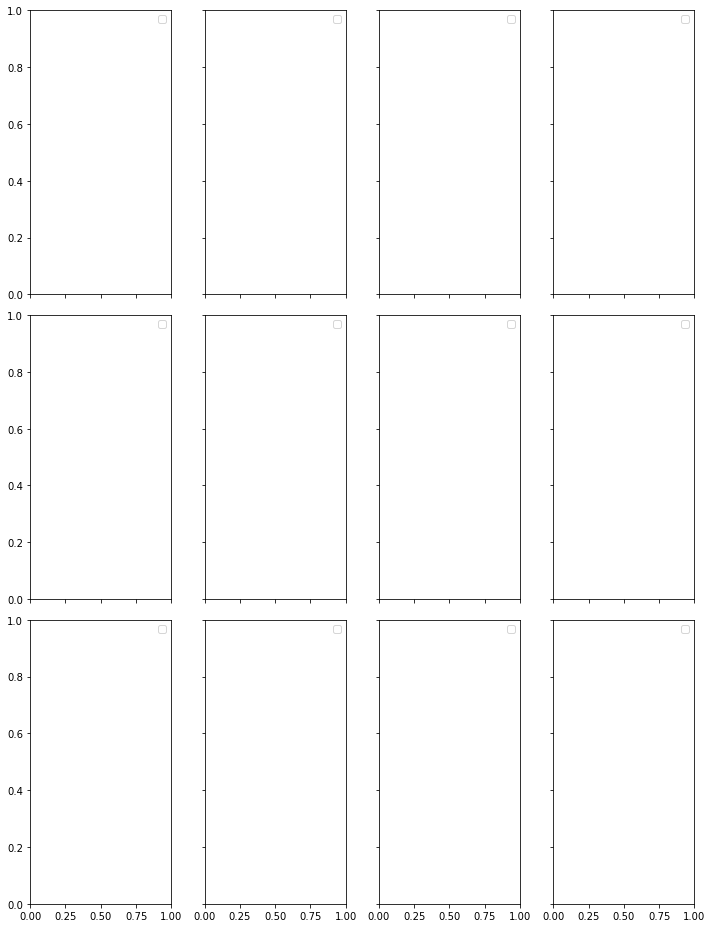

06242021_AuNR_Nirvana


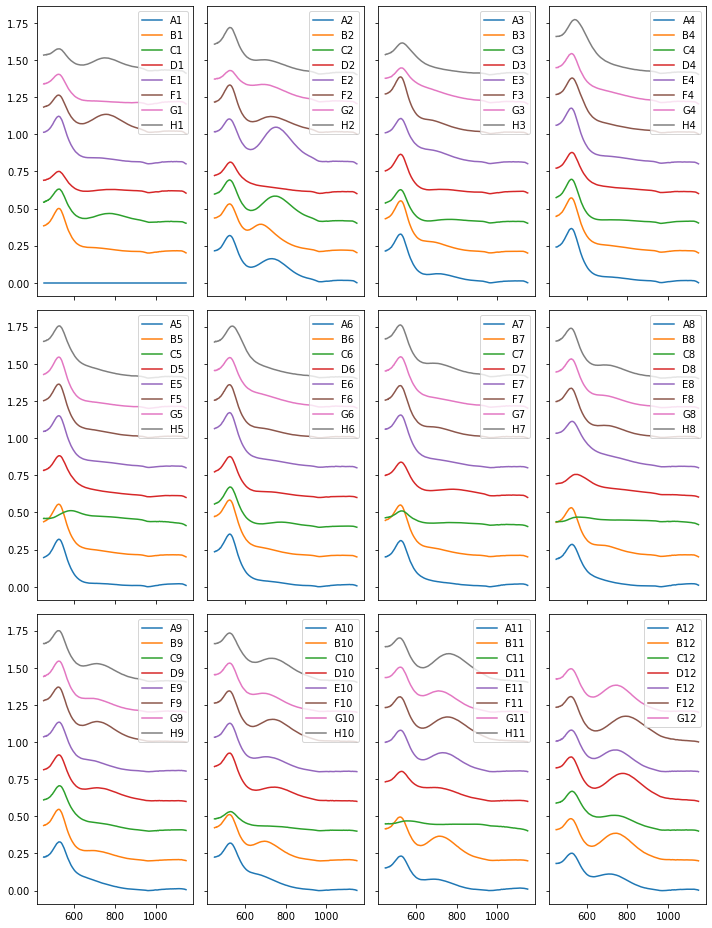

06252021_AuNR_Nirvana


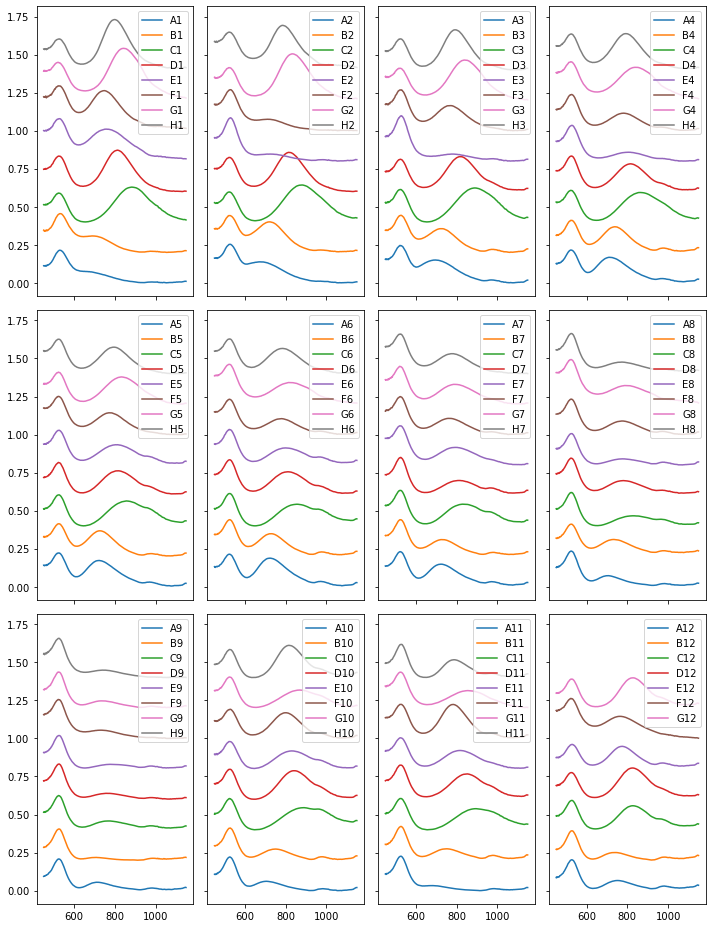

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


06252021_AuNR_Nirvana_round_2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


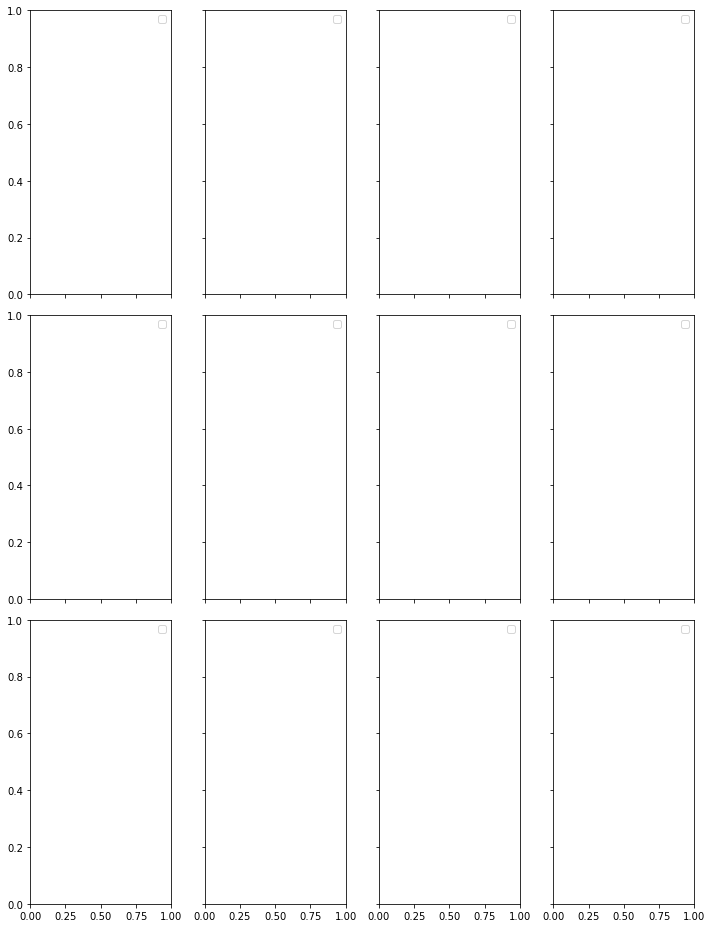

In [12]:
for j in range(4):
    print(names[j])
    fig,ax = plt.subplots(3,4,figsize = (10,13),sharex = True, sharey = True)
    ax = [a for sublist in ax for a in sublist]
    absorption = np.arange(450,1150,1)
    absorption_str = []
    absorption_float_str = []
    for k in absorption:
        absorption_str.append(str(k))
        absorption_float_str.append(str(float(k)))
    for b in range(1,13):
        num = 0
        for val in 'ABCDEFGH':
            # if not val+str(b) =='H12':
            try:
                row = Nirvana_merges[j].loc[Nirvana_merges[j]['Name'] == val+str(b)]
                spectrum = np.asarray(row[absorption_str])[0]
                # print(spectrum)
                ax[b-1].plot(absorption, spectrum + num,label = val+str(b))
                num +=0.2
            except:
                pass
        ax[b-1].legend()
    fig.tight_layout()
    plt.show()

In [13]:
spec1 = np.asarray(Nirvana_merges[1].loc[Nirvana_merges[1]['Name'] == 'D12'][absorption_str])[0]
spec1 = spec1 - min(spec1)
spec1 = spec1/max(spec1)

spec2 = np.asarray(Nirvana_merges[2].loc[Nirvana_merges[2]['Name'] == 'F5'][absorption_str])[0]
spec2 = spec2 - min(spec2)
spec2 = spec2/max(spec2)

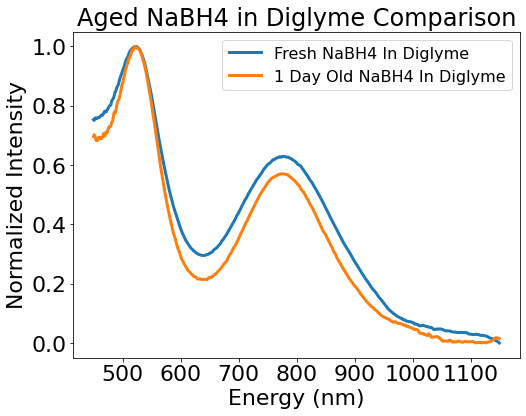

In [14]:

plt.figure(figsize = (8,6))
plt.xlabel('Energy (nm)', fontsize = 22)
plt.ylabel('Normalized Intensity', fontsize = 22)
plt.title('Aged NaBH4 in Diglyme Comparison', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.plot(absorption,spec1,label = 'Fresh NaBH4 In Diglyme', linewidth = 3)
plt.plot(absorption,spec2,label = '1 Day Old NaBH4 In Diglyme', linewidth = 3)
plt.legend(fontsize = 16)
plt.show()
